# Evaluación inicial de modelos de imagen TensorFlow Lite

Este notebook sirve para probar el funcionamiento de un modelo de imagen TensorFlow Lite.
## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from joblib import load
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import time

from image_model_evaluation import COLOR_MODE

## Parámetros

In [2]:
quantized = True
project_dir = "/home/daniel/PycharmProjects/tfg-tinyml"
saved_models_dir = f"{project_dir}/saved models/image"
label_index_dir = f"{saved_models_dir}/label index mappings"
# model_name = f"MicroImgDataModelQAT"
model_name = f"MicroImgDataModel"


label_index_path = f"{label_index_dir}/{model_name}.joblib"
test_dir = f"{project_dir}/samples/microcontroller/preprocessed image/test"

if quantized and model_name[-3:] != "QAT":
    model_name = f"{model_name}Quant"

model_path = f"{saved_models_dir}/tensorflow lite/{model_name}.tflite"

show_interval = 1

## Carga del modelo
Cargamos un modelo y mostramos un resumen de su estructura.

In [3]:
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

class_names = load(label_index_path)
class_indexes = {}
for index, name in enumerate(class_names):
    class_indexes[name] = index

## Inferencia
Se realiza inferencia sobre los archivos de la carpeta test y se muestran los resultados.

Testing 24 images from class mask.


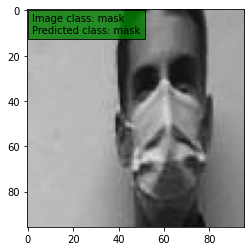

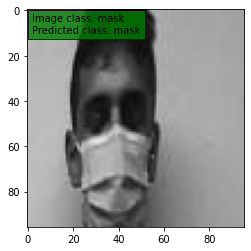

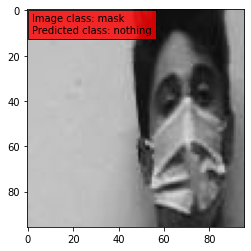

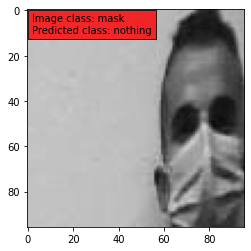

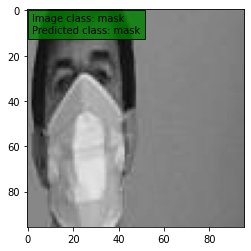

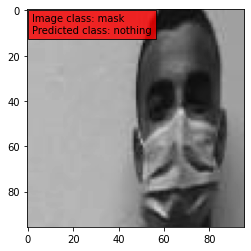

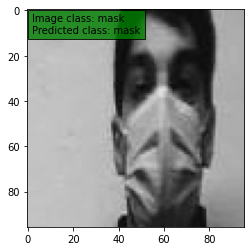

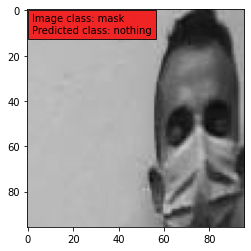

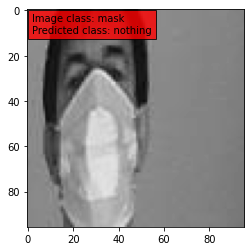

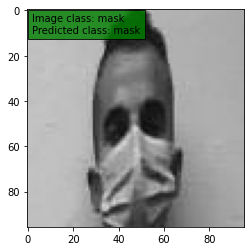

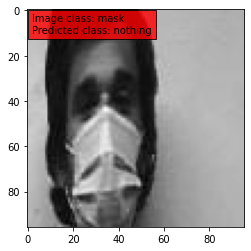

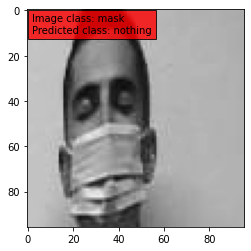

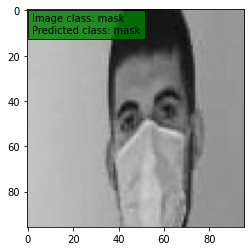

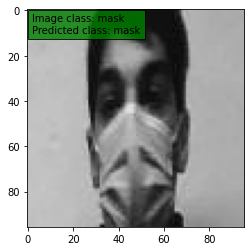

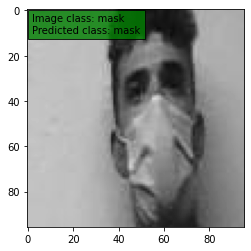

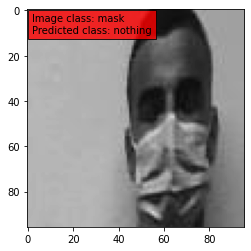

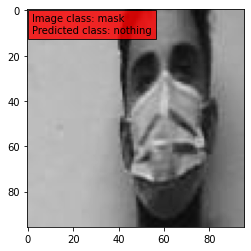

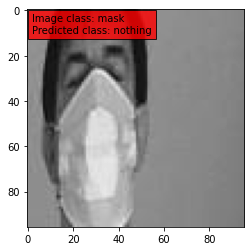

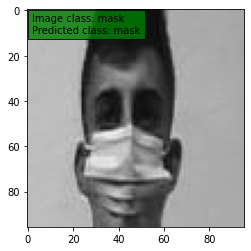

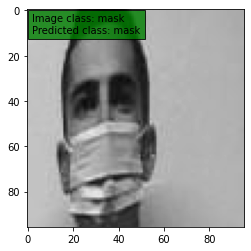

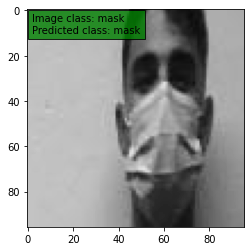

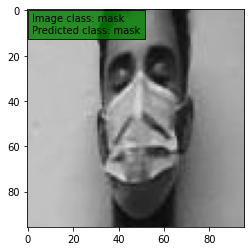

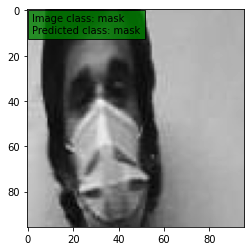

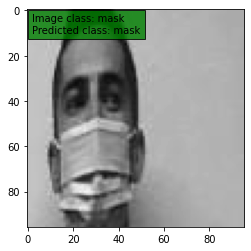

Testing 24 images from class face.


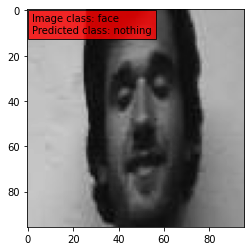

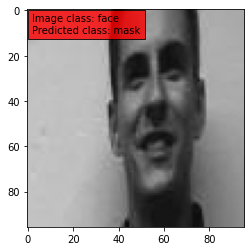

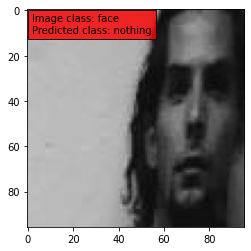

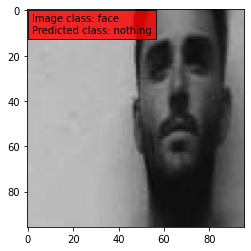

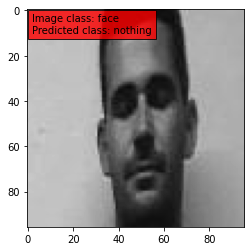

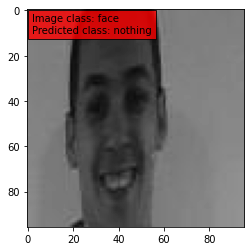

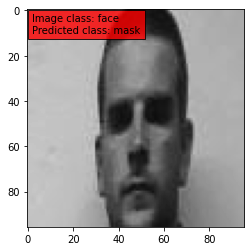

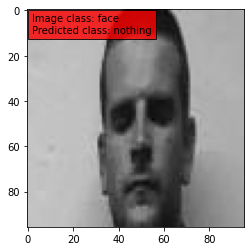

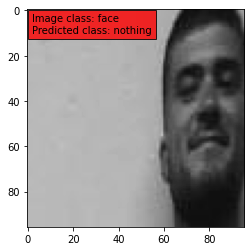

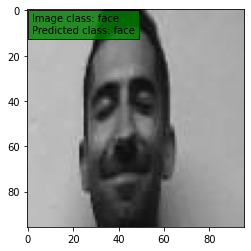

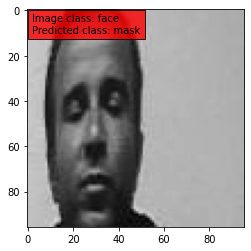

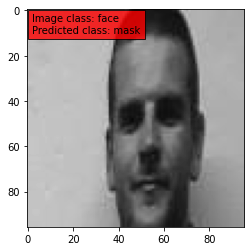

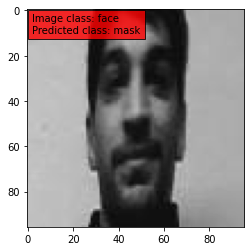

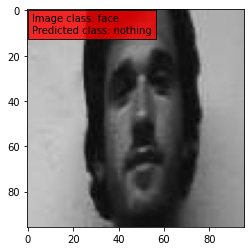

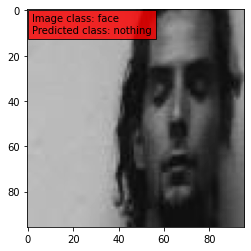

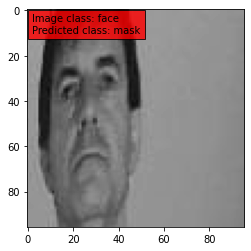

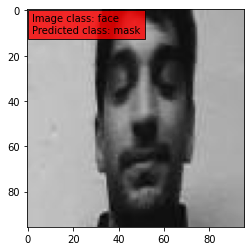

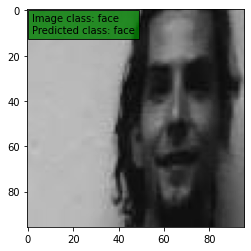

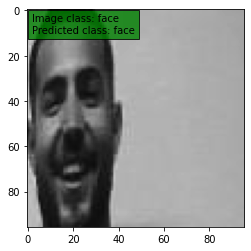

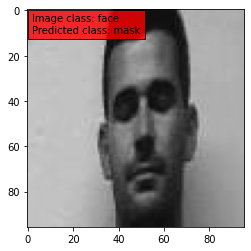

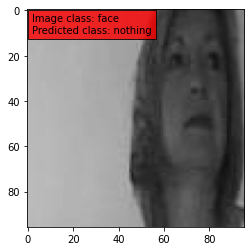

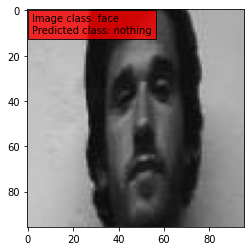

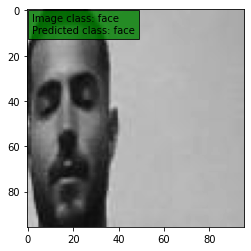

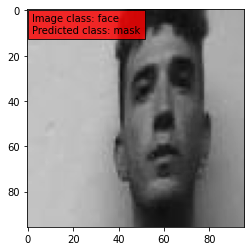

Testing 21 images from class nothing.


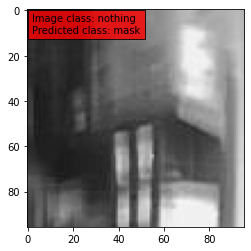

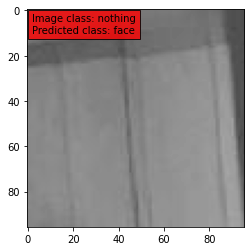

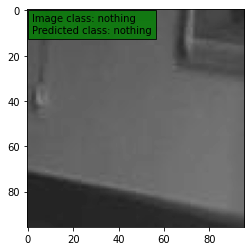

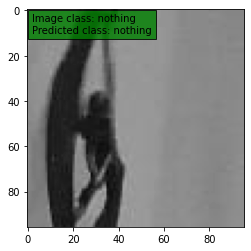

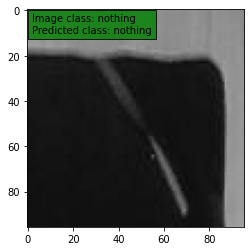

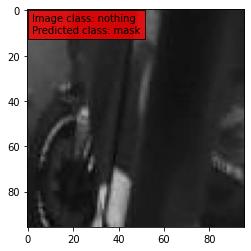

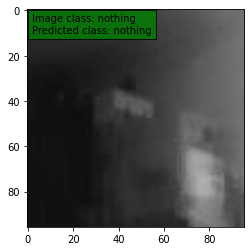

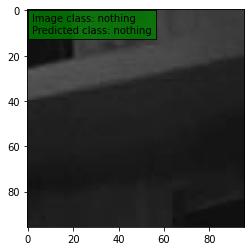

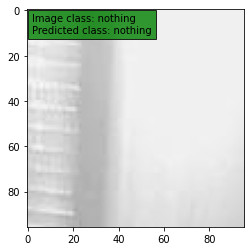

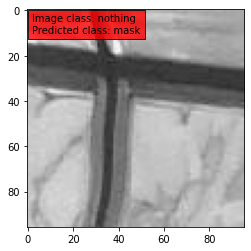

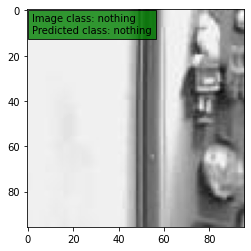

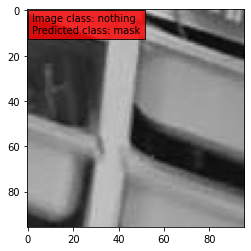

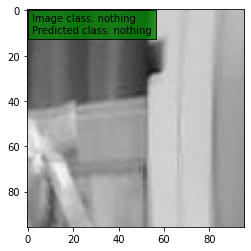

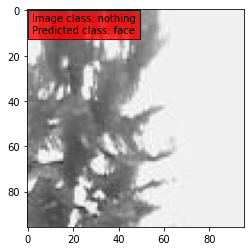

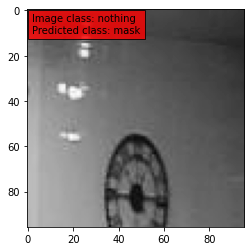

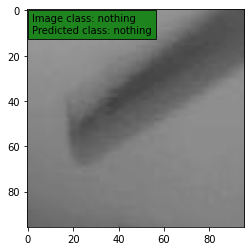

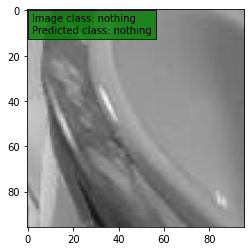

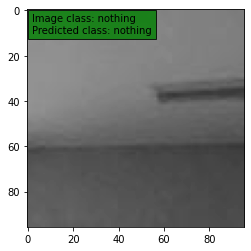

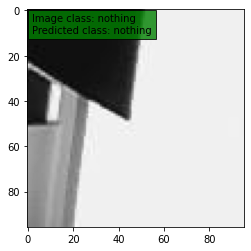

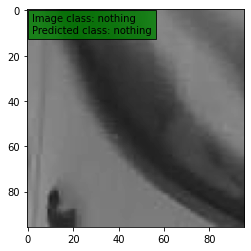

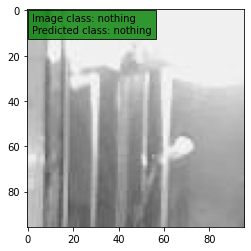

In [4]:
predictions = []
true_labels = []
times = []

classes = os.listdir(test_dir)
show_counter = 0

for name in classes:
    class_dir = f"{test_dir}/{name}"
    files = os.listdir(class_dir)
    print(f"Testing {len(files)} images from class {name}.")
    class_index = class_indexes[name]
    for file in files:
        true_labels.append(class_index)

        file_path = f"{test_dir}/{name}/{file}"

        img = load_img(file_path, color_mode=COLOR_MODE)
        img_array = img_to_array(img)

        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            img_array = img_array / input_scale + input_zero_point

        img_array = np.expand_dims(img_array, axis=0).astype(input_details["dtype"])


        interpreter.set_tensor(input_details["index"], img_array)

        t_ini = time.time()
        interpreter.invoke()
        t_end = time.time()
        elapsed = (t_end - t_ini) * 1000  # ms
        times.append(elapsed)

        prediction = interpreter.get_tensor(output_details["index"])[0]

        if quantized:
            score = prediction
            score_word = "score"
        else:
            score = tf.nn.softmax(prediction)
            score_word = "confidence"

        predicted_class = prediction.argmax()
        predictions.append(predicted_class)
        prediction_score = np.max(score)

        if show_counter % show_interval == 0 or predicted_class != class_index:
            if predicted_class == class_index:
                text_color = "green"
            else:
                text_color = "red"
            plt.figure()
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            plt.text(2, 10, f"Image class: {name}\nPredicted class: {class_names[predicted_class]}", color="black",
                     bbox=dict(facecolor=text_color, alpha=0.8))
            plt.show()

        show_counter +=1

## Visualización de métricas

Se muestran datos acerca del comportamiento general del modelo al evaluar las muestras.

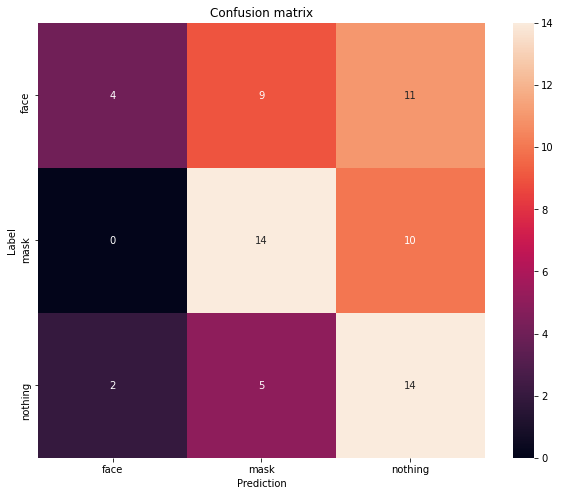

              precision    recall  f1-score   support

        face       0.67      0.17      0.27        24
        mask       0.50      0.58      0.54        24
     nothing       0.40      0.67      0.50        21

    accuracy                           0.46        69
   macro avg       0.52      0.47      0.44        69
weighted avg       0.53      0.46      0.43        69

Model size 45.578125 Kb
Average time: 10.064394577689793 ms
Max time: 35.99977493286133 ms
Min time: 8.885860443115234 ms


In [5]:
confusion_mtx = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion matrix")
plt.show()
print(classification_report(true_labels, predictions, target_names=class_names))

avg_time = sum(times) / len(times)
max_time = max(times)
min_time = min(times)

print(f"Model size {os.path.getsize(model_path) / 1024} Kb")

print(f"Average time: {avg_time} ms\nMax time: {max_time} ms\nMin time: {min_time} ms")

